In [0]:
import math
import random
import numpy as np
from scipy.stats import norm
from tqdm import tqdm as _tqdm
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

import seaborn as sns
sns.set(color_codes=True)

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)

In [0]:
# Functions for Black-Scholes formulas
def option_value_bs(St, K, T, sigma, r, t=0):
    d1 = (math.log(St/K) + (r + sigma ** 2 * 0.5) * (T - t)) / (sigma * math.sqrt(T - t))
    d2 = d1 - sigma * math.sqrt(T - t)
    
    return St * norm.cdf(d1) - K * math.exp(-r * (T - t)) * norm.cdf(d2)

def hedge_parameter_bs(St, K, T, sigma, r, t=0):
    return norm.cdf((math.log(St/K) + (r + sigma ** 2 * 0.5) * (T - t)) / (sigma * math.sqrt(T - t)))

## FD-Schemes for European call

In [0]:
def FD_Schemes(S0=100, K=110, T=1, v=0.3, r=0.04, M1=-5, M2=7, N_X=1000, N_T=1000, scheme='FTCS'):
    assert scheme in ['FTCS', 'CN'], 'Not a valid scheme type'
    # Initialization
    X0 = math.log(S0)
    
    grid = np.zeros((N_X+2, N_T+1))
    x_values = np.linspace(M1, M2, N_X+2)
    
    delta_x = x_values[2] - x_values[1]
    delta_tau = T / float(N_T)
    
    x_index = np.arange(1, N_X+1)
    tau_index = np.arange(1, N_T+1)
    
    # Setup boundaries on first column and last row
    grid[:, 0] = np.maximum(np.exp(x_values) - K, 0)
    grid[-1, 1:] = (np.exp(M2) - K) * np.exp(-r * tau_index * delta_tau)
    
    # Define coefficients to use in both schemes
    a = (2 * r - v**2) * delta_tau / (4 * delta_x)
    b = v**2 * delta_tau / (2 * delta_x**2)
    c = r * delta_tau + v**2 * delta_tau / (delta_x**2)
    
    # Compute coefficients and construct matrices A and B
    if scheme is 'FTCS':
        alpha =  - a + b
        beta = 1 - c
        gamma = a + b
        
        A = np.diag([alpha for i in range(N_X-1)], -1) + \
            np.diag([beta for i in range(N_X)]) + \
            np.diag([gamma for i in range(N_X-1)], 1)
        
        B = np.identity(N_X)
        B_inv = B
    else:
        alpha = (a - b) / 2
        beta = c / 2
        gamma = (- a - b) / 2
        
        A = np.diag([-alpha for i in range(N_X-1)], -1) + \
            np.diag([1-beta for i in range(N_X)]) + \
            np.diag([-gamma for i in range(N_X-1)], 1)
        
        B = np.diag([alpha for i in range(N_X-1)], -1) + \
            np.diag([1+beta for i in range(N_X)]) + \
            np.diag([gamma for i in range(N_X-1)], 1)
        B_inv = np.linalg.inv(B)
    
    # Traverse the grid
    for t in tau_index:
        # Get V^n from grid
        V_prev = grid[1:-1, t-1]
        
        if scheme is 'FTCS':
            # k_1 is 0
            k_new = np.zeros(N_X)
            
            # Construct k_2
            k_prev = np.zeros(N_X)
            k_prev[0] = 0
            k_prev[-1] = gamma * grid[-1, t-1]
        else:
            # Construct k_1
            k_new = np.zeros(N_X)
            k_new[0] = 0
            k_new[-1] = gamma * grid[-1, t]
            
            # Construct k_2
            k_prev = np.zeros(N_X)
            k_prev[0] = 0
            k_prev[-1] = -gamma * grid[-1, t-1]
        
        # Compute V^{n+1}
        grid[1:-1, t] = B_inv.dot(A.dot(V_prev) + k_prev - k_new)
    
    # Interpolate value of option by looking at the last column of the grid
    opt_value = np.interp(X0, x_values, grid[:, -1])
    
    return opt_value, grid, np.exp(x_values), delta_x, delta_tau

---
### Pricing the 3 call options

In [0]:
f_M1 = -5
f_M2 = 7
f_N_X = 1000
f_N_T = 1000

--- 

In the money ($S_0 = 100$, Black-Scholes $= 9.62535$)

In [0]:
bs_opt_value = option_value_bs(100, 110, 1, 0.3, 0.04)

In [6]:
opt_val, grid, _, dX, dT = FD_Schemes(S0=100, K=110, T=1, v=0.3, r=0.04,
                                      M1=f_M1, M2=f_M2, N_X=f_N_X, N_T=f_N_T, scheme='FTCS')
print('Option value: %.4f     Delta_X: %.4f     Delta_tau: %.4f' % (opt_val, dX, dT))
error = (opt_val / bs_opt_value - 1) * 100
print('Relative error: %.4f%%' % error)

Option value: 9.6283     Delta_X: 0.0120     Delta_tau: 0.0010
Relative error: 0.0308%


In [7]:
opt_val, grid, _, dX, dT = FD_Schemes(S0=100, K=110, T=1, v=0.3, r=0.04,
                                      M1=f_M1, M2=f_M2, N_X=f_N_X, N_T=f_N_T, scheme='CN')
print('Option value: %.4f     Delta_X: %.4f     Delta_tau: %.4f' % (opt_val, dX, dT))
error = (opt_val / bs_opt_value - 1) * 100
print('Relative error: %.4f%%' % error)

Option value: 9.6269     Delta_X: 0.0120     Delta_tau: 0.0010
Relative error: 0.0165%


---

At the money ($S_0 = 110$, Black-Scholes $= 15.12859$)

In [0]:
bs_opt_value_2 = option_value_bs(110, 110, 1, 0.3, 0.04)

In [9]:
opt_val, grid, _, dX, dT = FD_Schemes(S0=110, K=110, T=1, v=0.3, r=0.04,
                                      M1=f_M1, M2=f_M2, N_X=f_N_X, N_T=f_N_T, scheme='FTCS')
print('Option value: %.4f     Delta_X: %.4f     Delta_tau: %.4f' % (opt_val, dX, dT))
error = (opt_val / bs_opt_value_2 - 1) * 100
print('Relative error: %.4f%%' % error)

Option value: 15.1316     Delta_X: 0.0120     Delta_tau: 0.0010
Relative error: 0.0202%


In [10]:
opt_val, grid, _, dX, dT = FD_Schemes(S0=110, K=110, T=1, v=0.3, r=0.04,
                                      M1=f_M1, M2=f_M2, N_X=f_N_X, N_T=f_N_T, scheme='CN')
print('Option value: %.4f     Delta_X: %.4f     Delta_tau: %.4f' % (opt_val, dX, dT))
error = (opt_val / bs_opt_value_2 - 1) * 100
print('Relative error: %.4f%%' % error)

Option value: 15.1299     Delta_X: 0.0120     Delta_tau: 0.0010
Relative error: 0.0086%


---

Out of the money ($S_0 = 120$, Black-Scholes $= 21.78882$)

In [0]:
bs_opt_value_3 = option_value_bs(120, 110, 1, 0.3, 0.04)

In [12]:
opt_val, grid, _, dX, dT = FD_Schemes(S0=120, K=110, T=1, v=0.3, r=0.04,
                                  M1=f_M1, M2=f_M2, N_X=f_N_X, N_T=f_N_T, scheme='FTCS')
print('Option value: %.4f     Delta_X: %.4f     Delta_tau: %.4f' % (opt_val, dX, dT))
error = (opt_val / bs_opt_value_3 - 1) * 100
print('Relative error: %.4f%%' % error)

Option value: 21.7935     Delta_X: 0.0120     Delta_tau: 0.0010
Relative error: 0.0217%


In [13]:
opt_val, grid, _, dX, dT = FD_Schemes(S0=120, K=110, T=1, v=0.3, r=0.04,
                                  M1=f_M1, M2=f_M2, N_X=f_N_X, N_T=f_N_T, scheme='CN')
print('Option value: %.4f     Delta_X: %.4f     Delta_tau: %.4f' % (opt_val, dX, dT))
error = (opt_val / bs_opt_value_3 - 1) * 100
print('Relative error: %.4f%%' % error)

Option value: 21.7919     Delta_X: 0.0120     Delta_tau: 0.0010
Relative error: 0.0140%


### 3D Plots

In [0]:
def plot_3d_grid(S0, K, T, v, r, M1, M2, N_X, N_T, scheme, restrict=True, savefig=False):
    print(f'Scheme {scheme}')
    opt_value, grid, _, _, _ = FD_Schemes(S0=S0, K=K, T=T, v=v, r=r,
                                          M1=M1, M2=M2, N_X=N_X, N_T=N_T, scheme=scheme)
    
    fig = plt.figure(figsize=(10, 8))
    ax = Axes3D(fig)
    if restrict:
        x_range = np.linspace(M1, M2, f_N_X+2)
        idx = np.where(x_range > 3.5)[0][0]
        grid = grid[idx:, :]
    else:
        idx = 0
    t, X = np.meshgrid(np.linspace(0, 1, N_T+1), np.linspace(M1, M2, N_X+2)[idx:])
    
    ax.plot_surface(X, t, grid, cmap='coolwarm', linewidth=0, antialiased=True)
    ax.view_init(20, 100)
    ax.set_xlabel('X')
    ax.set_ylabel('tau')
    ax.set_zlabel('option price')
    if savefig:
        plt.savefig(f'3d_grid_{scheme}_restrict_{restrict}.png', dpi=200)
    plt.show()

In [0]:
f_M1 = -5
f_M2 = 7
f_N_X = 1000
f_N_T = 1000

Scheme CN


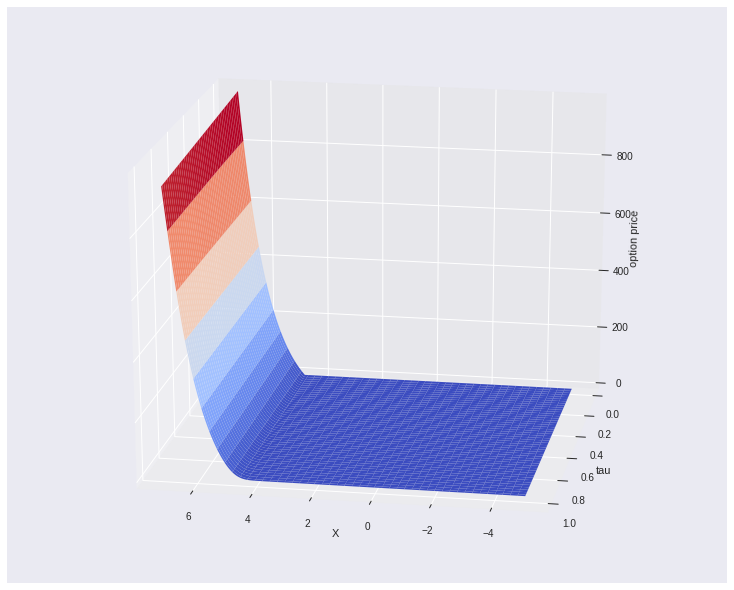

In [18]:
plot_3d_grid(S0=100, K=110, T=1, v=0.3, r=0.04, M1=f_M1, M2=f_M2, N_X=f_N_X, N_T=f_N_T, scheme='CN', restrict=False)

Scheme CN


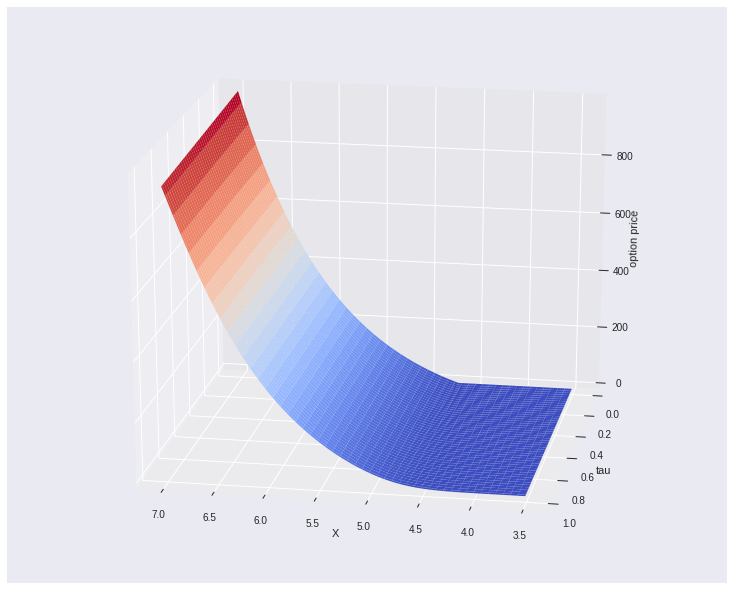

In [21]:
plot_3d_grid(S0=100, K=110, T=1, v=0.3, r=0.04, M1=f_M1, M2=f_M2, N_X=f_N_X, N_T=f_N_T, scheme='CN', restrict=True)

Scheme FTCS


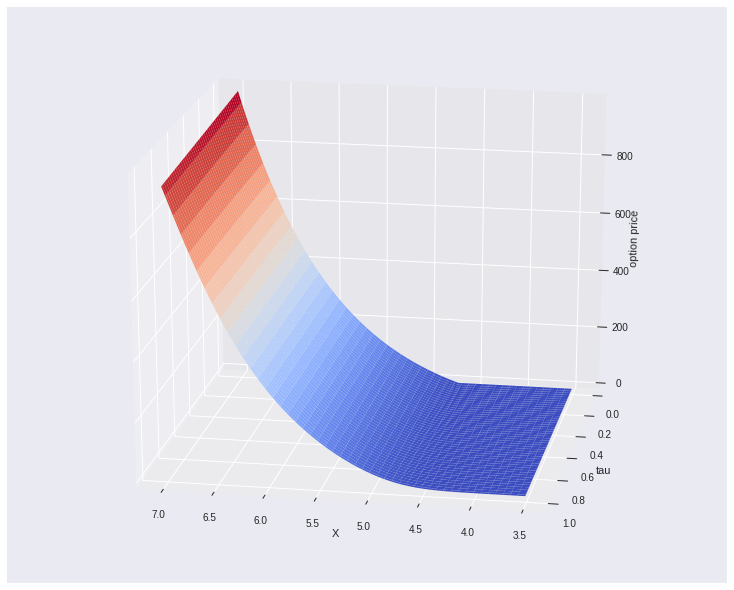

In [22]:
plot_3d_grid(S0=100, K=110, T=1, v=0.3, r=0.04, M1=f_M1, M2=f_M2, N_X=f_N_X, N_T=f_N_T, scheme='FTCS', restrict=True)

### Experiments of stability and consistency with different mesh size

#### Experiments with different $N_X$ and $N_T$

In [0]:
f_M1 = -5
f_M2 = 7
N_X_tests = [500, 1000]
N_T_tests = [50, 100, 150, 250, 500, 1000, 2000, 3000]

bs_opt_value = option_value_bs(St=100, K=110, T=1, sigma=0.3, r=0.04)

---
FTCS Scheme

In [28]:
for f_N_X in N_X_tests:
    for f_N_T in N_T_tests:
        opt_val, grid, _, dX, dT = FD_Schemes(S0=100, K=110, T=1, v=0.3, r=0.04,
                                              M1=f_M1, M2=f_M2, N_X=f_N_X, N_T=f_N_T, scheme='FTCS')
        print(f'N_X: {f_N_X}     N_T: {f_N_T}')
        print(f'Option value: {opt_val}     Delta_X: {dX:.4f}     Delta_tau: {dT:.4f}')
        error = (opt_val / bs_opt_value - 1) * 100
        print(f'Relative error: {error}%')
        print('\n\n')
    print('---------------------------------------------')

N_X: 500     N_T: 50
Option value: -4.579665298284429e+34     Delta_X: 0.0240     Delta_tau: 0.0200
Relative error: -4.757916931213548e+35%



N_X: 500     N_T: 100
Option value: -2.6189756827020935e+31     Delta_X: 0.0240     Delta_tau: 0.0100
Relative error: -2.720912540886507e+32%



N_X: 500     N_T: 150
Option value: -10605.779888124142     Delta_X: 0.0240     Delta_tau: 0.0067
Relative error: -110285.82453467316%



N_X: 500     N_T: 250
Option value: 9.623252254609897     Delta_X: 0.0240     Delta_tau: 0.0040
Relative error: -0.021875282677707997%



N_X: 500     N_T: 500
Option value: 9.620494413854685     Delta_X: 0.0240     Delta_tau: 0.0020
Relative error: -0.05052710845137032%



N_X: 500     N_T: 1000
Option value: 9.61911613937489     Delta_X: 0.0240     Delta_tau: 0.0010
Relative error: -0.06484631096106419%



N_X: 500     N_T: 2000
Option value: 9.61842716387589     Delta_X: 0.0240     Delta_tau: 0.0005
Relative error: -0.07200423185348415%



N_X: 500     N_T: 3000
Op

---
CN Scheme

In [30]:
for f_N_X in N_X_tests:
    for f_N_T in N_T_tests:
        opt_val, grid, _, dX, dT = FD_Schemes(S0=100, K=110, T=1, v=0.3, r=0.04,
                                              M1=f_M1, M2=f_M2, N_X=f_N_X, N_T=f_N_T, scheme='CN')
        print(f'N_X: {f_N_X}     N_T: {f_N_T}')
        print(f'Option value: {opt_val}     Delta_X: {dX:.4f}     Delta_tau: {dT:.4f}')
        error = (opt_val / bs_opt_value - 1) * 100
        print(f'Relative error: {error}%')
        print('\n\n')
print('---------------------------------------------')

N_X: 500     N_T: 50
Option value: 9.617853321094382     Delta_X: 0.0240     Delta_tau: 0.0200
Relative error: -0.07796601313695417%



N_X: 500     N_T: 100
Option value: 9.617767052933615     Delta_X: 0.0240     Delta_tau: 0.0100
Relative error: -0.07886227239609633%



N_X: 500     N_T: 150
Option value: 9.617751077064574     Delta_X: 0.0240     Delta_tau: 0.0067
Relative error: -0.07902824928054386%



N_X: 500     N_T: 250
Option value: 9.617742897385867     Delta_X: 0.0240     Delta_tau: 0.0040
Relative error: -0.07911322979610169%



N_X: 500     N_T: 500
Option value: 9.617739446576476     Delta_X: 0.0240     Delta_tau: 0.0020
Relative error: -0.07914908102836238%



N_X: 500     N_T: 1000
Option value: 9.61773858387296     Delta_X: 0.0240     Delta_tau: 0.0010
Relative error: -0.07915804384855951%



N_X: 500     N_T: 2000
Option value: 9.617738368195479     Delta_X: 0.0240     Delta_tau: 0.0005
Relative error: -0.07916028457025659%



N_X: 500     N_T: 3000
Option value: 9.61

#### Experiments with different $N_X$ for CN Scheme

In [0]:
f_M1 = -5
f_M2 = 7
N_X_tests = [x for x in range(1000, 10001, 1000)]
f_N_T = 1000

pred = []
abs_errors_CN = []

bs_opt_value = option_value_bs(St=100, K=110, T=1, sigma=0.3, r=0.04)

In [41]:
for f_N_X in N_X_tests:
    opt_val, grid, _, dX, dT = FD_Schemes(S0=100, K=110, T=1, v=0.3, r=0.04,
                                          M1=f_M1, M2=f_M2, N_X=f_N_X, N_T=f_N_T, scheme='CN')
    pred.append(opt_val)
    print(f'N_X: {f_N_X}     N_T: {f_N_T}')
    print(f'Option value: {opt_val}     Delta_X: {dX:.4f}     Delta_tau: {dT:.4f}')
    error = (opt_val / bs_opt_value - 1) * 100
    abs_error = abs(opt_val - bs_opt_value)
    abs_errors_CN.append(abs_error)
    print(f'Relative error: {error}%         Absolute error: {abs_error:.6f}')
    print('---------------------------------------------')

N_X: 1000     N_T: 1000
Option value: 9.626943853973769     Delta_X: 0.0120     Delta_tau: 0.0010
Relative error: 0.016477570582562606%         Absolute error: 0.001586
---------------------------------------------
N_X: 2000     N_T: 1000
Option value: 9.626137207513475     Delta_X: 0.0060     Delta_tau: 0.0010
Relative error: 0.008097139697427203%         Absolute error: 0.000779
---------------------------------------------
N_X: 3000     N_T: 1000
Option value: 9.625311008493522     Delta_X: 0.0040     Delta_tau: 0.0010
Relative error: -0.00048642711271140726%         Absolute error: 0.000047
---------------------------------------------
N_X: 4000     N_T: 1000
Option value: 9.625552468548872     Delta_X: 0.0030     Delta_tau: 0.0010
Relative error: 0.002022155525382985%         Absolute error: 0.000195
---------------------------------------------
N_X: 5000     N_T: 1000
Option value: 9.625378071214936     Delta_X: 0.0024     Delta_tau: 0.0010
Relative error: 0.00021030253209985972%

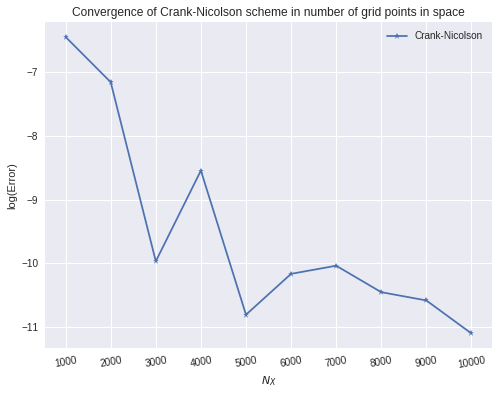

In [45]:
# Plot convergence error
fig = plt.figure(figsize=(8, 6))
ax=fig.gca()
ax.plot(N_X_tests, np.log(abs_errors_CN), '*-')
ticks = ax.set_xticks(N_X_tests)
labels = ax.set_xticklabels([str(x) for x in N_X_tests], rotation=10, fontsize='small')
ax.set_xlabel('$N_X$')
ax.set_ylabel('log(Error)')
ax.set_title('Convergence of Crank-Nicolson scheme in number of grid points in space')
plt.legend(['Crank-Nicolson'])
plt.show()

### Convergence comparison between FTCS scheme and Crank-Nicolson scheme

In [0]:
def error_of_convergence(N_X_list, N_T_list, S0=100, K=110, T=1, v=0.3, r=0.04, M1=-5, M2=7, scheme='FTCS'):
    predicted = []
    delta_X = []
    for N_X, N_T in zip(N_X_list, N_T_list):
        opt_val, _, _, dX, _ = FD_Schemes(S0, K, T, v, r, M1, M2, N_X, N_T, scheme)
        predicted.append(opt_val)
        delta_X.append(dX)
    bs_value = option_value_bs(S0, K, T, v, r)
    error = np.abs(np.array(predicted) - bs_value)
    return error, delta_X

In [0]:
N_X_list = np.array([50, 100, 200, 400, 800])
N_T_list = np.array([100, 200, 400, 800, 1600])
error_FTCS, dX_FTCS = error_of_convergence(N_X_list, N_T_list, S0=100, K=110, T=1, v=0.3, r=0.04,
                                           M1=0, M2=7, scheme='FTCS')
error_CN, dX_CN = error_of_convergence(N_X_list, N_T_list, S0=100, K=110, T=1, v=0.3, r=0.04,
                                       M1=0, M2=7, scheme='CN')


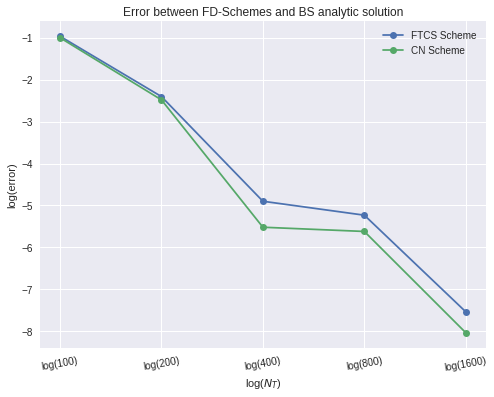

In [33]:
# Plot convergence error
fig = plt.figure(figsize=(8, 6))
ax=fig.gca()
plt.plot(np.log(N_T_list), np.log(error_FTCS), 'o-')
plt.plot(np.log(N_T_list), np.log(error_CN), 'o-')
plt.xticks(np.log(N_T_list), [f'log({x})' for x in N_T_list], rotation=10, fontsize='small')
plt.xlabel('log($N_T$)')
plt.ylabel('log(error)')
plt.title('Error between FD-Schemes and BS analytic solution')
plt.legend(['FTCS Scheme', 'CN Scheme'])
plt.show()

### Compute Delta and plot

In [0]:
def compute_and_plot_delta(S0=100, K=110, T=1, v=0.3, r=0.04, M1=-5, M2=7, N_X=2000, N_T=1000, scheme='CN',
                           restrict=True, S_min=10, S_max=200, savefig=False):
    # Get FD Scheme data
    _, grid, S0_val, _, _ = FD_Schemes(S0, K, T, v, r, M1, M2, N_X, N_T, scheme=scheme)
    
    x_values = np.linspace(M1, M2, N_X+2)
    V = grid[:, -1]
    
    # Compute deltas for FD Schemes, either restricted to interval or on full domain
    fd_delta = []
    bs_delta = []
    if not restrict:
        for i in np.arange(1, N_X+1):
            fd_delta.append((V[i+1] - V[i-1]) / (S0_val[i+1] - S0_val[i-1]))
            bs_delta.append(hedge_parameter_bs(S0_val[i], K, T, v, r))

        S0_val = S0_val[1:-1]
    else:
        S_values = np.arange(S_min-1, S_max+1, 1)
        
        for i in np.arange(1, len(S_values)-1):
            V_i = np.interp(np.log(S_values[i-1]), x_values, V)
            V_i_next = np.interp(np.log(S_values[i+1]), x_values, V)
            fd_delta.append((V_i_next - V_i) / (S_values[i+1] - S_values[i-1]))
            bs_delta.append(hedge_parameter_bs(S_values[i], K, T, v, r))
        S0_val = S_values[1:-1]
    
    # Plot lines
    plt.figure(figsize=(12, 10))
    plt.plot(S0_val, fd_delta, label=scheme, alpha=0.8)
    plt.plot(S0_val, bs_delta, label='Black-Scholes', alpha=0.6)
    plt.xlabel('$S_0$')
    plt.ylabel('Delta')
    plt.legend()
    if savefig:
        plt.savefig(f'delta_N_X_{N_X}_restrict_{restrict}.png', dpi=200)
    plt.show()
    
    if restrict:
        fd_d = np.array(fd_delta)
        bs_d = np.array(bs_delta)
        print(f'Mean absolute error: {np.mean(np.abs(fd_d - bs_d)):.6f}')

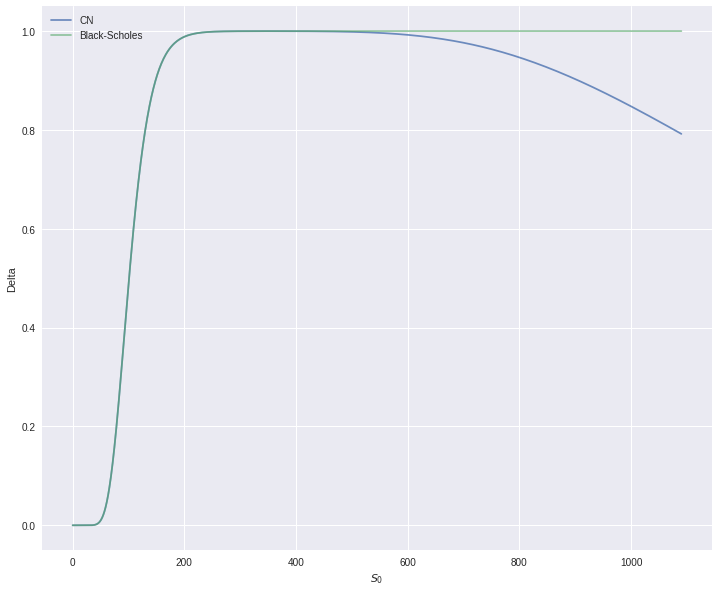

In [35]:
compute_and_plot_delta(N_X=2000, N_T=1000, scheme='CN', restrict=False)

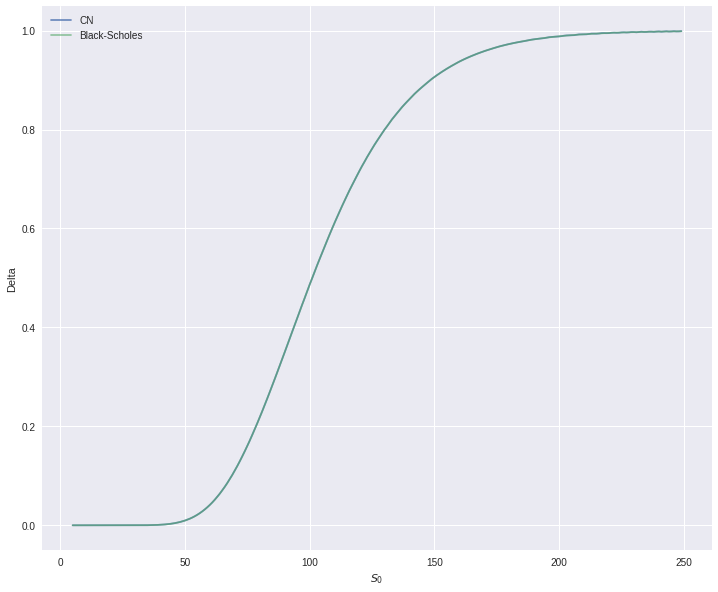

Mean absolute error: 0.000134


In [36]:
compute_and_plot_delta(N_X=2000, N_T=1000, scheme='CN', restrict=True, S_min=5, S_max=250, savefig=True)

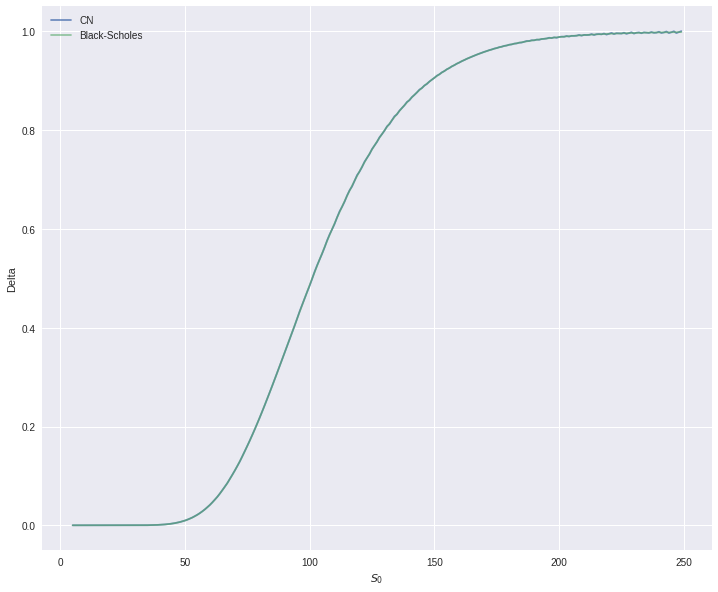

Mean absolute error: 0.000411


In [37]:
compute_and_plot_delta(N_X=1000, N_T=1000, scheme='CN', restrict=True, S_min=5, S_max=250, savefig=True)

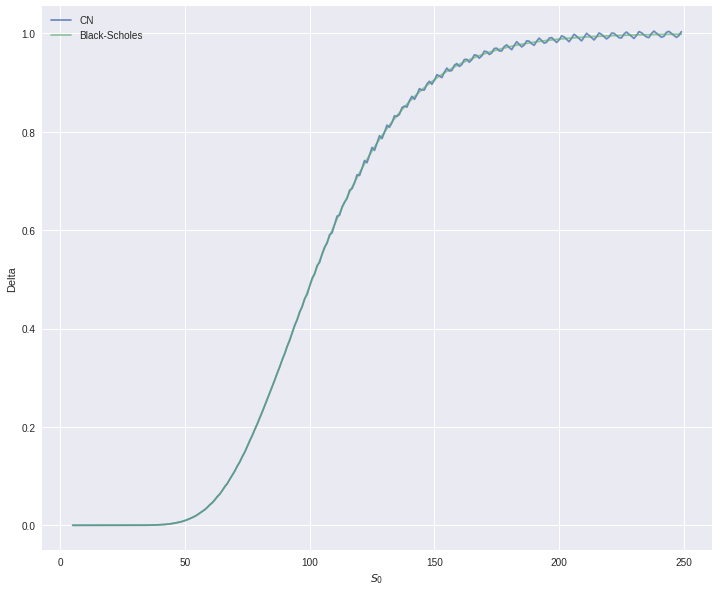

Mean absolute error: 0.002409


In [38]:
compute_and_plot_delta(N_X=500, N_T=1000, scheme='CN', restrict=True, S_min=5, S_max=250, savefig=True)

# OTHER STUFF

In [0]:
f_M1 = -5
f_M2 = 7
N_X_tests = [x for x in range(1000, 10001, 1000)]
f_N_T = 1000

pred = []
abs_errors_CN = []

bs_opt_value = option_value_bs(St=100, K=110, T=1, sigma=0.3, r=0.04)

In [0]:
for f_N_X in N_X_tests:
    
    opt_val, grid, _, dX, dT = FD_Schemes(S0=100, K=110, T=1, v=0.3, r=0.04,
                                          M1=f_M1, M2=f_M2, N_X=f_N_X, N_T=f_N_T, scheme='CN')
    pred.append(opt_val)
    print(f'N_X: {f_N_X}     N_T: {f_N_T}')
    print(f'Option value: {opt_val}     Delta_X: {dX:.4f}     Delta_tau: {dT:.4f}')
    error = (opt_val / bs_opt_value - 1) * 100
    abs_error = abs(opt_val - bs_opt_value)
    abs_errors_CN.append(abs_error)
    print(f'Relative error: {error}%         Absolute error: {abs_error:.6f}')
    print(f'{f_N_X} & {f_N_T} & {dT:.5f} & {opt_val:.7f} & {error:.6f}\% & {abs_error:.6f} \\\\')
    print('\n\n')
    print('---------------------------------------------')

N_X: 1000     N_T: 1000
Option value: 9.626943853973769     Delta_X: 0.0120     Delta_tau: 0.0010
Relative error: 0.016477570582562606%         Absolute error: 0.001586
1000 & 1000 & 0.00100 & 9.6269439 & 0.016478\% & 0.001586 \\



---------------------------------------------
N_X: 2000     N_T: 1000
Option value: 9.626137207513475     Delta_X: 0.0060     Delta_tau: 0.0010
Relative error: 0.008097139697427203%         Absolute error: 0.000779
2000 & 1000 & 0.00100 & 9.6261372 & 0.008097\% & 0.000779 \\



---------------------------------------------
N_X: 3000     N_T: 1000
Option value: 9.625311008493522     Delta_X: 0.0040     Delta_tau: 0.0010
Relative error: -0.00048642711271140726%         Absolute error: 0.000047
3000 & 1000 & 0.00100 & 9.6253110 & -0.000486\% & 0.000047 \\



---------------------------------------------
N_X: 4000     N_T: 1000
Option value: 9.625552468548872     Delta_X: 0.0030     Delta_tau: 0.0010
Relative error: 0.002022155525382985%         Absolute error:

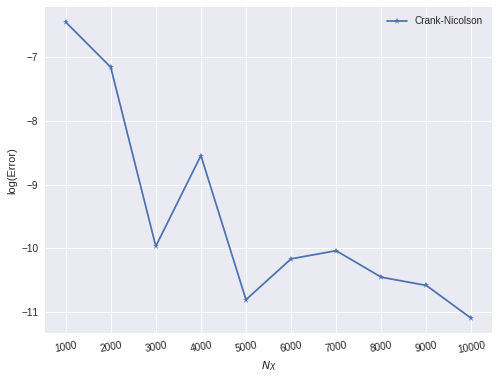

In [0]:
# Plot convergence error
fig = plt.figure(figsize=(8, 6))
ax=fig.gca()
ax.plot(N_X_tests, np.log(abs_errors_CN), '*-')
ticks = ax.set_xticks(N_X_tests)
labels = ax.set_xticklabels([str(x) for x in N_X_tests], rotation=10, fontsize='small')
ax.set_xlabel('$N_X$')
ax.set_ylabel('log(Error)')
# ax.set_title('Convergence of Crank-Nicolson scheme in number of grid points in space')
plt.legend(['Crank-Nicolson'])
plt.savefig('convergence_cn.png', dpi=200)
plt.show()